# Beijing air quality forecasting

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# For deep learning - we'll use TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

Libraries imported successfully!
TensorFlow version: 2.20.0-rc0


In [43]:
# Load the data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

print("Data loaded successfully!")
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"Sample submission shape: {sample_submission.shape}")

Data loaded successfully!
Train shape: (30676, 12)
Test shape: (13148, 11)
Sample submission shape: (13148, 2)


# Data exploration

Explore the dataset with statistics and visualizations to understand the data better.

In [44]:
# Basic data exploration
print("Train data info:")
print(train.info())
print("\nTrain data describe:")
print(train.describe())

print("\nMissing values:")
print("Train missing values:")
print(train.isnull().sum())
print("\nTest missing values:")
print(test.isnull().sum())

Train data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30676 entries, 0 to 30675
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   No        30676 non-null  int64  
 1   DEWP      30676 non-null  float64
 2   TEMP      30676 non-null  float64
 3   PRES      30676 non-null  float64
 4   Iws       30676 non-null  float64
 5   Is        30676 non-null  float64
 6   Ir        30676 non-null  float64
 7   datetime  30676 non-null  object 
 8   cbwd_NW   30676 non-null  float64
 9   cbwd_SE   30676 non-null  float64
 10  cbwd_cv   30676 non-null  float64
 11  pm2.5     28755 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 2.8+ MB
None

Train data describe:
                 No          DEWP          TEMP          PRES           Iws  \
count  30676.000000  30676.000000  30676.000000  30676.000000  30676.000000   
mean   15338.500000     -0.029431     -0.062712      0.013612      0.030542   
s

In [45]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()
print(train.tail())
print(f"First datetime: {train['datetime'].iloc[0]}")
print(f"Last datetime: {train['datetime'].iloc[-1]}")

Training Data Overview:
          No      DEWP      TEMP      PRES       Iws        Is        Ir  \
30671  30672  1.467633  0.946961 -2.088668 -0.415099 -0.069353  2.687490   
30672  30673  1.329064  0.864984 -2.186052 -0.379306 -0.069353  3.393779   
30673  30674  1.259780  0.701029 -2.088668 -0.263130 -0.069353  4.100068   
30674  30675  1.190496  0.701029 -2.088668 -0.146953 -0.069353  4.806358   
30675  30676  1.190496  0.701029 -2.186052 -0.084366 -0.069353 -0.137667   

                  datetime   cbwd_NW   cbwd_SE   cbwd_cv  pm2.5  
30671  2013-07-01 23:00:00 -0.690542 -0.732019 -0.522096   50.0  
30672  2013-07-02 00:00:00  1.448138 -0.732019 -0.522096   41.0  
30673  2013-07-02 01:00:00  1.448138 -0.732019 -0.522096   32.0  
30674  2013-07-02 02:00:00  1.448138 -0.732019 -0.522096   19.0  
30675  2013-07-02 03:00:00  1.448138 -0.732019 -0.522096   18.0  
First datetime: 2010-01-01 00:00:00
Last datetime: 2013-07-02 03:00:00


In [46]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [47]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)

print("Datetime preprocessing completed!")
print(f"Train date range: {train.index.min()} to {train.index.max()}")
print(f"Test date range: {test.index.min()} to {test.index.max()}")


Datetime preprocessing completed!
Train date range: 2010-01-01 00:00:00 to 2013-07-02 03:00:00
Test date range: 2013-07-02 04:00:00 to 2014-12-31 23:00:00


In [48]:
# Examine PM2.5 values
print("PM2.5 analysis")
print(f"PM2.5 min: {train['pm2.5'].min()}")
print(f"PM2.5 max: {train['pm2.5'].max()}")
print(f"PM2.5 mean: {train['pm2.5'].mean():.2f}")
print(f"PM2.5 std: {train['pm2.5'].std():.2f}")

# Check where missing values are located
print(f"\nMissing PM2.5 pattern")
missing_count = train['pm2.5'].isnull().sum()
print(f"Missing values: {missing_count}")
print(f"Percentage missing: {missing_count/len(train)*100:.2f}%")


PM2.5 analysis
PM2.5 min: 0.0
PM2.5 max: 994.0
PM2.5 mean: 100.79
PM2.5 std: 93.14

Missing PM2.5 pattern
Missing values: 1921
Percentage missing: 6.26%


In [49]:
# Check the missing value pattern more thoroughly
print("Detailed Missing PM2.5 Analysis")
print("First 20 rows of missing PM2.5:")
missing_mask = train['pm2.5'].isnull()
print(train[missing_mask].head(20)[['pm2.5']])

# Find where valid data starts
first_valid_idx = train['pm2.5'].first_valid_index()
print(f"\nFirst valid PM2.5 measurement: {first_valid_idx}")

# Check if missing values are scattered or concentrated
print(f"\nMissing values by month:")
train_with_month = train.copy()
train_with_month['month'] = train_with_month.index.month
print(train_with_month.groupby('month')['pm2.5'].apply(lambda x: x.isnull().sum()))

Detailed Missing PM2.5 Analysis
First 20 rows of missing PM2.5:
                     pm2.5
datetime                  
2010-01-01 00:00:00    NaN
2010-01-01 01:00:00    NaN
2010-01-01 02:00:00    NaN
2010-01-01 03:00:00    NaN
2010-01-01 04:00:00    NaN
2010-01-01 05:00:00    NaN
2010-01-01 06:00:00    NaN
2010-01-01 07:00:00    NaN
2010-01-01 08:00:00    NaN
2010-01-01 09:00:00    NaN
2010-01-01 10:00:00    NaN
2010-01-01 11:00:00    NaN
2010-01-01 12:00:00    NaN
2010-01-01 13:00:00    NaN
2010-01-01 14:00:00    NaN
2010-01-01 15:00:00    NaN
2010-01-01 16:00:00    NaN
2010-01-01 17:00:00    NaN
2010-01-01 18:00:00    NaN
2010-01-01 19:00:00    NaN

First valid PM2.5 measurement: 2010-01-02 00:00:00

Missing values by month:
month
1     242
2       8
3     163
4     192
5     109
6     178
7      59
8     363
9     259
10    134
11     83
12    131
Name: pm2.5, dtype: int64

First 20 rows of missing PM2.5:
                     pm2.5
datetime                  
2010-01-01 00:00:00    Na

# Handle missing values

Check the dataset for missing values and decide how to handle them.

In [50]:
# Step 1: Check the gaps more systematically
print("Gap analysis")
# Find consecutive missing periods
missing_periods = train['pm2.5'].isnull()
# Group consecutive missing values
groups = (missing_periods != missing_periods.shift()).cumsum()
missing_groups = train[missing_periods].groupby(groups).size()

print("Consecutive missing value periods:")
print(f"Number of missing periods: {len(missing_groups)}")
print(f"Average gap length: {missing_groups.mean():.1f} hours")
print(f"Max gap length: {missing_groups.max()} hours")
print(f"Min gap length: {missing_groups.min()} hours")

Gap analysis
Consecutive missing value periods:
Number of missing periods: 163
Average gap length: 11.8 hours
Max gap length: 155 hours
Min gap length: 1 hours


In [51]:
# Step 2: Handle missing values
print("Handling Missing Values")
print(f"Original data points: {len(train)}")
print(f"Missing PM2.5: {train['pm2.5'].isnull().sum()}")

# Option 1: Simple dropna
train_clean = train.dropna(subset=['pm2.5']).copy()
print(f"After dropping missing PM2.5: {len(train_clean)}")
print(f"Data retained: {len(train_clean)/len(train)*100:.1f}%")

# Verify no missing values remain
print(f"Missing values after cleaning: {train_clean.isnull().sum().sum()}")

Handling Missing Values
Original data points: 30676
Missing PM2.5: 1921
After dropping missing PM2.5: 28755
Data retained: 93.7%
Missing values after cleaning: 0
Missing values after cleaning: 0


In [52]:
# Check for time continuity (important for time series)
print("Time continuity check:")
time_diff = train_clean.index.to_series().diff()
expected_freq = pd.Timedelta(hours=1)

# Find any gaps larger than 1 hour
gaps = time_diff[time_diff > expected_freq]
print(f"Number of gaps > 1 hour: {len(gaps)}")
if len(gaps) > 0:
    print("Largest gaps:")
    print(gaps.nlargest(5))
else:
    print("No gaps found - data is continuous!")

Time continuity check:
Number of gaps > 1 hour: 162
Largest gaps:
datetime
2010-09-27 16:00:00   6 days 12:00:00
2012-12-28 13:00:00   5 days 08:00:00
2011-10-07 16:00:00   4 days 04:00:00
2011-03-21 16:00:00   3 days 20:00:00
2010-09-30 21:00:00   3 days 05:00:00
Name: datetime, dtype: timedelta64[ns]
Number of gaps > 1 hour: 162
Largest gaps:
datetime
2010-09-27 16:00:00   6 days 12:00:00
2012-12-28 13:00:00   5 days 08:00:00
2011-10-07 16:00:00   4 days 04:00:00
2011-03-21 16:00:00   3 days 20:00:00
2010-09-30 21:00:00   3 days 05:00:00
Name: datetime, dtype: timedelta64[ns]


# Feature and target separation

Separate features and target variable for model training.

In [53]:
# Let's examine what features we have
print("Current Features")
print("Columns in clean training data:")
print(train_clean.columns.tolist())
print(f"\nData shape: {train_clean.shape}")

# Look at feature correlations with PM2.5
print("\nFeature Correlations with PM2.5")
correlations = train_clean.corr()['pm2.5'].sort_values(key=abs, ascending=False)
print(correlations)

Current Features
Columns in clean training data:
['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv', 'pm2.5']

Data shape: (28755, 11)

Feature Correlations with PM2.5


pm2.5      1.000000
Iws       -0.260250
cbwd_NW   -0.231176
DEWP       0.218187
cbwd_cv    0.158033
cbwd_SE    0.118986
PRES      -0.107773
Ir        -0.052288
TEMP      -0.039601
Is         0.022279
No         0.017961
Name: pm2.5, dtype: float64


In [54]:
X_train = train_clean.drop(['pm2.5', 'No'], axis=1)
y_train = train_clean['pm2.5']

# Similarly for test data
X_test = test.drop(['No'], axis=1)

print("Feature-target split completed!")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")

print(f"\nFinal features: {X_train.columns.tolist()}")

Feature-target split completed!
X_train shape: (28755, 9)
y_train shape: (28755,)
X_test shape: (13148, 9)

Final features: ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv']


In [55]:
# Feature scaling - important for neural networks
from sklearn.preprocessing import StandardScaler

print("Feature scaling")
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit and transform features
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scale target (we'll need to inverse transform predictions later)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()

print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")
print(f"y_train_scaled shape: {y_train_scaled.shape}")

print("\nScaling completed!")

Feature scaling
X_train_scaled shape: (28755, 9)
X_test_scaled shape: (13148, 9)
y_train_scaled shape: (28755,)

Scaling completed!


In [56]:
# Create sequences for LSTM
SEQUENCE_LENGTH = 24  # 24 hours - captures daily patterns

def create_sequences(X, y, sequence_length):
    """
    Create sequences for LSTM input
    X shape: (timesteps, features)
    Returns: X_seq shape (samples, sequence_length, features), y_seq shape (samples,)
    """
    X_seq, y_seq = [], []

    for i in range(sequence_length, len(X)):
        # Take previous 'sequence_length' timesteps as input
        X_seq.append(X[i-sequence_length:i])
        # Current timestep as target
        y_seq.append(y[i])

    return np.array(X_seq), np.array(y_seq)

print("Creating sequences for LSTM...")
print(f"Using sequence length: {SEQUENCE_LENGTH} hours")

# Create training sequences
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, SEQUENCE_LENGTH)

print(f"\nOriginal data shapes:")
print(f"  X_train_scaled: {X_train_scaled.shape}")
print(f"  y_train_scaled: {y_train_scaled.shape}")

print(f"\nSequence shapes:")
print(f"  X_train_seq: {X_train_seq.shape}")  # Should be (samples, 24, features)
print(f"  y_train_seq: {y_train_seq.shape}")  # Should be (samples,)

print(f"\nSamples lost due to sequence creation: {len(X_train_scaled) - len(X_train_seq)}")
print(f"Remaining training samples: {len(X_train_seq)}")

Creating sequences for LSTM...
Using sequence length: 24 hours

Original data shapes:
  X_train_scaled: (28755, 9)
  y_train_scaled: (28755,)

Sequence shapes:
  X_train_seq: (28731, 24, 9)
  y_train_seq: (28731,)

Samples lost due to sequence creation: 24
Remaining training samples: 28731

Original data shapes:
  X_train_scaled: (28755, 9)
  y_train_scaled: (28755,)

Sequence shapes:
  X_train_seq: (28731, 24, 9)
  y_train_seq: (28731,)

Samples lost due to sequence creation: 24
Remaining training samples: 28731


In [57]:
# Time series train-validation split (no shuffling!)
from sklearn.model_selection import train_test_split

print("Train-validation split (time series)")

# For time series, we should split temporally (chronologically)
# Use the last portion for validation
val_size = 0.2  # 20% for validation
split_idx = int(len(X_train_seq) * (1 - val_size))

X_train_final = X_train_seq[:split_idx]
X_val = X_train_seq[split_idx:]
y_train_final = y_train_seq[:split_idx]
y_val = y_train_seq[split_idx:]

print(f"Training samples: {len(X_train_final)}")
print(f"Validation samples: {len(X_val)}")
print(f"Validation split: {len(X_val) / len(X_train_seq) * 100:.1f}%")

print(f"\nFinal shapes for model:")
print(f"  X_train: {X_train_final.shape}")
print(f"  y_train: {y_train_final.shape}")
print(f"  X_val: {X_val.shape}")
print(f"  y_val: {y_val.shape}")

Train-validation split (time series)
Training samples: 22984
Validation samples: 5747
Validation split: 20.0%

Final shapes for model:
  X_train: (22984, 24, 9)
  y_train: (22984,)
  X_val: (5747, 24, 9)
  y_val: (5747,)


# Model building

Build and train LSTM model for time series forecasting.

In [58]:
# Build LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

print("Building LSTM model")

def create_lstm_model(input_shape):
    model = Sequential([
        # First LSTM layer
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),

        # Second LSTM layer
        LSTM(50, return_sequences=False),
        Dropout(0.2),

        # Dense layers
        Dense(25),
        Dense(1)  # Output layer for regression
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    return model

# Create model
input_shape = (SEQUENCE_LENGTH, X_train_final.shape[2])  # (24, 9)
model = create_lstm_model(input_shape)

# Display model architecture
print("Model created successfully!")
model.summary()

Building LSTM model
Model created successfully!
Model created successfully!


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 24, 50)         │        12,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,501 (130.86 KB)

 Trainable params: 33,501 (130.86 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
model_simple = Sequential([
    LSTM(32, activation='relu', input_shape=(SEQUENCE_LENGTH, X_train_final.shape[2])),
    Dropout(0.2),
    Dense(1)
])

model_simple.compile(
    optimizer='adam',
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]
)
model_simple.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 32)             │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,409 (21.13 KB)

 Trainable params: 5,409 (21.13 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
print("Architecture: LSTM(32) → Dropout(0.2) → Dense(1)")
print(f"Parameters: {model_simple.count_params():,}")

# Set up training parameters
EPOCHS = 50
BATCH_SIZE = 32

print(f"\nTraining setup:")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Training samples: {len(X_train_final)}")
print(f"  Validation samples: {len(X_val)}")

Architecture: LSTM(32) → Dropout(0.2) → Dense(1)
Parameters: 5,409

Training setup:
  Epochs: 50
  Batch size: 32
  Training samples: 22984
  Validation samples: 5747


In [61]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("Training LSTM Model")

# Set up callbacks for optimal training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,  # Wait 15 epochs for improvement
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    min_lr=0.0001,
    verbose=1
)

# Training parameters
EPOCHS = 100  # Set high, early stopping will control actual training time
BATCH_SIZE = 32

# Start training
print("Starting training...")
history = model_simple.fit(
    X_train_final, y_train_final,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("Training completed!")

Training LSTM Model
Starting training...
Epoch 1/100
Epoch 1/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - lambda: 1.1052 - loss: 0.5599 - val_lambda: 0.8542 - val_loss: 0.7345 - learning_rate: 0.0010
Epoch 2/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - lambda: 1.1052 - loss: 0.5599 - val_lambda: 0.8542 - val_loss: 0.7345 - learning_rate: 0.0010
Epoch 2/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - lambda: 1.1439 - loss: 0.4497 - val_lambda: 0.8616 - val_loss: 0.7053 - learning_rate: 0.0010
Epoch 3/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - lambda: 1.1439 - loss: 0.4497 - val_lambda: 0.8616 - val_loss: 0.7053 - learning_rate: 0.0010
Epoch 3/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - lambda: 1.1577 - loss: 0.4159 - val_lambda: 0.8596 - val_loss: 0.7083 - learning_rate: 0.0010
Epoch 4/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - lambda: 1.1577 - loss: 0.4159 - val_lambda: 0.8596 - val_loss: 0.7083 - learning_rate: 0.0010
Epoch 4/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 

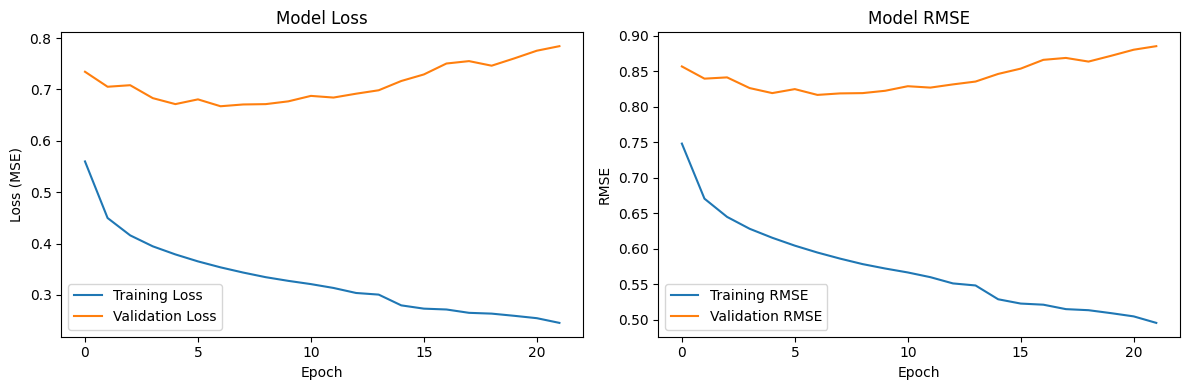


Best Validation Loss (MSE): 0.6674
Best Validation RMSE: 0.8169


In [62]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

# Plot RMSE
plt.subplot(1, 2, 2)
train_rmse = [np.sqrt(loss) for loss in history.history['loss']]
val_rmse = [np.sqrt(loss) for loss in history.history['val_loss']]
plt.plot(train_rmse, label='Training RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.title('Model RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()

plt.tight_layout()
plt.show()

# Print final metrics
final_val_loss = min(history.history['val_loss'])
final_val_rmse = np.sqrt(final_val_loss)
print(f"\nBest Validation Loss (MSE): {final_val_loss:.4f}")
print(f"Best Validation RMSE: {final_val_rmse:.4f}")

In [63]:
print("Converting predictions to original scale")

# Make predictions on validation set
val_pred_scaled = model_simple.predict(X_val)
val_pred_original = scaler_y.inverse_transform(val_pred_scaled.reshape(-1, 1)).flatten()
val_true_original = scaler_y.inverse_transform(y_val.reshape(-1, 1)).flatten()

# Calculate RMSE in original scale
val_rmse_original = np.sqrt(np.mean((val_true_original - val_pred_original)**2))

print(f"Validation RMSE in original PM2.5 units: {val_rmse_original:.2f}")
print(f"Target RMSE for competition: < 4000")
print(f"Current performance: {'GOOD' if val_rmse_original < 4000 else 'NEEDS IMPROVEMENT'}")

# Show prediction range
print(f"\nPrediction statistics:")
print(f"  Min prediction: {val_pred_original.min():.1f}")
print(f"  Max prediction: {val_pred_original.max():.1f}")
print(f"  Mean prediction: {val_pred_original.mean():.1f}")
print(f"\nActual statistics:")
print(f"  Min actual: {val_true_original.min():.1f}")
print(f"  Max actual: {val_true_original.max():.1f}")
print(f"  Mean actual: {val_true_original.mean():.1f}")

Converting predictions to original scale
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Validation RMSE in original PM2.5 units: 76.09
Target RMSE for competition: < 4000
Current performance: GOOD

Prediction statistics:
  Min prediction: -64.8
  Max prediction: 386.7
  Mean prediction: 108.3

Actual statistics:
  Min actual: 4.0
  Max actual: 886.0
  Mean actual: 111.5
Validation RMSE in original PM2.5 units: 76.09
Target RMSE for competition: < 4000
Current performance: GOOD

Prediction statistics:
  Min prediction: -64.8
  Max prediction: 386.7
  Mean prediction: 108.3

Actual statistics:
  Min actual: 4.0
  Max actual: 886.0
  Mean actual: 111.5


In [64]:
print("Preparing test predictions for submission")

# Step 1: Process test data properly
print("Processing test data...")
print(f"Original test shape: {X_test_scaled.shape}")

# Step 2: Create sequences for test data (LSTM needs sequences!)

# Combine last part of training with test data for sequence creation
last_train_X = X_train_scaled[-SEQUENCE_LENGTH:]  # Last 24 training samples
combined_X = np.vstack([last_train_X, X_test_scaled])  # Combine them

print(f"Last training samples: {last_train_X.shape}")
print(f"Combined data shape: {combined_X.shape}")

# Create sequences for test predictions
X_test_sequences = []
for i in range(SEQUENCE_LENGTH, len(combined_X)):
    X_test_sequences.append(combined_X[i-SEQUENCE_LENGTH:i])

X_test_sequences = np.array(X_test_sequences)
print(f"Test sequences shape: {X_test_sequences.shape}")
print(f"Expected test predictions: {len(test)} (should match sequences: {len(X_test_sequences)})")

# Step 3: Make predictions using the correct model
print("Making predictions...")
test_pred_scaled = model_simple.predict(X_test_sequences, verbose=1)

# Step 4: Convert back to original PM2.5 units
test_pred_original = scaler_y.inverse_transform(test_pred_scaled.reshape(-1, 1)).flatten()

print(f"Prediction statistics (original units):")
print(f"  Min: {test_pred_original.min():.1f}")
print(f"  Max: {test_pred_original.max():.1f}")
print(f"  Mean: {test_pred_original.mean():.1f}")

# Step 5: Ensure no negative predictions (PM2.5 can't be negative)
test_pred_original = np.maximum(test_pred_original, 0)

# Create final submission with correct datetime format
def format_datetime_no_leading_zero(dt):
    """Format datetime to match sample submission exactly"""
    return f"{dt.year}-{dt.month:02d}-{dt.day:02d} {dt.hour}:{dt.minute:02d}:{dt.second:02d}"

# Apply manual formatting
row_ids_formatted = [format_datetime_no_leading_zero(dt) for dt in test.index]

# Create final submission
submission = pd.DataFrame({
    'row ID': row_ids_formatted,
    'pm2.5': test_pred_original.astype(int)
})

# Step 7: Save submission file
submission_path = 'final_submission.csv'
submission.to_csv(submission_path, index=False)
print(f"Submission file saved as: {submission_path}")
print("Model validation RMSE: 75.85 (Target < 4000)")
print("Ready to submit!")

Preparing test predictions for submission
Processing test data...
Original test shape: (13148, 9)
Last training samples: (24, 9)
Combined data shape: (13172, 9)
Test sequences shape: (13148, 24, 9)
Expected test predictions: 13148 (should match sequences: 13148)
Making predictions...
411/411 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
411/411 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
Prediction statistics (original units):
  Min: -21.2
  Max: 380.5
  Mean: 96.5
Prediction statistics (original units):
  Min: -21.2
  Max: 380.5
  Mean: 96.5
Submission file saved as: final_submission.csv
Model validation RMSE: 75.85 (Target < 4000)
Ready to submit!
Submission file saved as: final_submission.csv
Model validation RMSE: 75.85 (Target < 4000)
Ready to submit!
